# Table Approximation via Neural Nets 
The purpose of this note is to share my own fun and my personal approach for learning new things (think about new problems to solve given some technology/methodology).

Ive been doing some research (for my own learning) on how I might train a model to calculate the expected value of various summary statistics of a table. For example, in Ads we might want to calculate CPM and CVR for the subset of a population but also determine the topline CPM or CVR. 

A pretty common way to do this (non-modeling) is to either write a query caluculating the statistics or to take a representative sample. A sample works really well except when the dimensionality of the input data is high (many columns in the table) - this can make it more difficult to make statements about specific columns.

However - we can also perform this task with ML models. In fact - we do this already in many parts of the company. For example - we have models that estimate CVR in Ads to rank the ads we see. Commonly - in this case we are interested in calcuating P(conversion | features data) which works really well for prediction tasks. If we are going to use a model to summarize the data then we also need to know P(features data) to get to expected value.

End state - we want to calculate metrics (CTR, CPM, CPC, Total Clicks, Total Impressions, Revenue) for arbitrary 'descriptors' (Geo, Age, Gender, Placement, Format, Optimization type ... potentially hundreds more). We also need to calculate P(descriptors).

Calculation of the metrics is pretty common practice. We can train a model (or models) that estimate each metric given the data. 

There is some pretty interesting research in density estimation: [Deep Mind](https://arxiv.org/pdf/1605.02226.pdf), [Lit Review](https://arxiv.org/pdf/1904.00176.pdf). I picked a pretty simple method which attempts to estimate the CDF given the data [formula 2](https://arxiv.org/pdf/1904.00176.pdf). 

CDF = P(x1>X1 AND x2>X2 ... x_n>X_n)

This is trivial to implement in the model. For each record we want to train on (A) - we sample a different record at random (B) and create the label for (A)s record as follows:

cdf_label = x1_a > x1_b AND x2_a > x2_b .... x_n_a > x_n_b 

As we train on 0, 1 labels, the model will bein to approximate the CDF given the data (X) because the label will be 1 at the rate corresponding to the CDF value.

Furthermore - Neural Networks allow us to do multi-objective regression/classification using the same base network. e.g. we can predict: CPM, CTR, CPC, cdf_label as a function of the 'descriptors' features.

This is incredibly powerful - if we can build such a model - we will have a very compressed representation of the data and only need ranges of input features (max, min values) to be able to reconstruct the metrics. 

As you will see below - this **almost** works. I think this direction in general is pretty promising - instead of writing queries against petabites of data - we might be able to query models instead. These models might be small enough that many of them could fit into memory on the client.

In [1]:
import torch
import time
import torch.nn
from torch.autograd import Variable
import torch.nn.functional as F
import math
from tqdm import tqdm_notebook as tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

torch.set_printoptions(precision=4, sci_mode=False)
np.set_printoptions( formatter={'float': '{: 0.4f}'.format})

In [2]:
# This class is used to train the neural net
class Trainer:
    def __init__(self, model, test_X, test_y, loss_fn, optimizer, eval_step_size=10):
        self.model = model
        self.test_X = test_X
        self.test_y = test_y
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        
        self.loss_results = []
        self.time_results = []
        self.num_steps = 0
        self.eval_step_size = eval_step_size
        
        
    def train_step(self, X, y):
        self.num_steps = self.num_steps + 1
        
        t0 = time.time()
        
        if len(self.time_results) > 0:
            min_time = self.time_results[-1]
        else:
            min_time = 0


        loss_results = []
        time_results = []


        if self.num_steps % self.eval_step_size == 1:

            if self.test_X is None:
                test_x = X
                test_y = y
            else:
                test_x = self.test_X
                test_y = self.test_y


            self.model.eval()
            # Forward pass: compute predicted y by passing x to the model.
            y_pred = self.model(test_x)

            # Compute and print loss.
            loss = self.loss_fn(y_pred, test_y)
            
            loss_results.append(loss.data.sum().tolist())
            time_results.append(int(time.time() - t0 + min_time))

        self.model.train()
        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable
        # weights of the model). This is because by default, gradients are
        # accumulated in buffers( i.e, not overwritten) whenever .backward()
        # is called. Checkout docs of torch.autograd.backward for more details.
        self.optimizer.zero_grad()

        # Forward pass: compute predicted y by passing x to the model.
        y_pred = self.model(X)

        # Compute and print loss.

        loss = self.loss_fn(y_pred, y)
        loss = loss.sum()

        # Backward pass: compute gradient of the loss with respect to model
        # parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its
        # parameters
        self.optimizer.step()
            
        self.loss_results.extend(loss_results)
        self.time_results.extend(time_results)

In [3]:
# helper class for the neural net - it is a list of functions/layers that get executed in order
class ListModule(torch.nn.Module):
    def __init__(self, *args):
        super(ListModule, self).__init__()
        idx = 0
        for module in args:
            self.add_module(str(idx), module)
            idx += 1

    def __getitem__(self, idx):
        if idx < 0 or idx >= len(self._modules):
            raise IndexError('index {} is out of range'.format(idx))
        it = iter(self._modules.values())
        for i in range(idx):
            next(it)
        return next(it)

    def __iter__(self):
        return iter(self._modules.values())

    def __len__(self):
        return len(self._modules)

    
    def forward(self, x):
        y = x
        for m in self:
            y = m(y)
        return y
    
    def __str__(self):
        ret = []
        for m in self:
            ret.append(str(m))
        return 'List ' + ' '.join(ret)

In [545]:
# this is a pretty standard neural net with the exception that the output variable correspoinding to the CDF
# is put though a sigmoid function to limit the range of possible values to (0,1).
class NeuralNet(torch.nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, 
                 activation=torch.nn.LeakyReLU, final_transform=None):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(NeuralNet, self).__init__()
        self.dropout_prob = 0.2 
        self.input_size = input_size
        self.output_size = output_size
        self.activation = activation()
        self.sigmoid = torch.nn.Sigmoid()
        
        last_size = input_size

        layers = []
        
        
        
        #layers.append(torch.nn.BatchNorm1d(input_size))

        #layers.append(torch.nn.Dropout(p=self.dropout_prob))
        
        for size in hidden_sizes:
            n = torch.nn.Linear(int(last_size), int(size))
            layers.append(n)
            last_size = size
            #layers.append(torch.nn.BatchNorm1d(size))
            layers.append(self.activation)
            #layers.append(torch.nn.Dropout(p=self.dropout_prob))
        
        n = torch.nn.Linear(int(last_size), int(output_size))
        layers.append(n)
        
        if final_transform:
            layers.append(final_transform())
        
        self.layers = ListModule(*layers)
        
        
    def forward(self, x):
        """
        In the forward function we accept a Variable of input data and we must return
        a Variable of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Variables.
        """
        x = self.layers(x)
        return torch.cat([
            x[:,:-1], self.sigmoid(x[:,-1:])
        ], 1)
    

In [546]:
# helper functions for normalizing output variables, this is useful to do as it puts all outputs
# on the same scale - this makes loss function treat each variable a little more equally
def norm(x):
    return (x - x.mean()) / x.std(), (x.mean(), x.std())

def de_norm(x, tup):
    u, std = tup
    return (x*std) + u

In [547]:
# two functions to calculate CDF values for a given record.

# sample a random record. 1 IF the current records features are greater than all of the sampled records features.
# zero otherwise.
def cdf_sample(y):
    resample = np.random.choice(len(y), size=len(y))
    
    return np.sum(y > y[resample], axis=1) >= y.shape[1]
    
    
# take a sample of the full dataset
# for each record calculate the CDF value based on the sample
# this is much slower but allows a continuous CDF value to be learned
# it does not appear to matter very much which function is used
def cdf_exact(y):
    
    sample = np.random.choice(len(y), size=10000)
    sample = y[sample]
    
    ret = []
    
    for yy in tqdm(y):
        
        val = np.less(sample, yy)
        val = np.all(val, axis=1)
        ret.append(val.mean())
            
    
    return ret
    
    
cdf_value = cdf_sample

In [548]:
# generate some example data and example output metrics based on the features.
# in our biz F would be demographics, page types, etc (the columns of the table)
# Y would be the metrics that we would want to calculate for the table
sz = 100000

f1 = np.random.normal(scale=1, size=sz)

f2 = np.random.random(size=sz)


y1 = f1 + 10 * f2 
y2 = (f1 > 1) * 20 + (f2 < 0.1) * 5 + 5

X = np.array([f1, f2])

y1, y1_param = norm(y1)
y2, y2_param = norm(y2)

Y = np.array([y1, y2])

cdf_x = np.array(cdf_value(X.transpose())).transpose()

In [549]:
Y = np.concatenate([[y1], [y2], [cdf_x]])

X = X.transpose()
Y = Y.transpose()

X_tensor = torch.cuda.FloatTensor(X)
Y_tensor = torch.cuda.FloatTensor(Y)


test_x, train_x = X_tensor[-5000:], X_tensor[:-5000]
test_y, train_y = Y_tensor[-5000:], Y_tensor[:-5000]

In [550]:
net = NeuralNet(X.shape[1], [400]*4, Y.shape[1])

net.cuda()

# this loss is not ideal for CDF calculation - BCE would be better but that would require a
# distinct net for CDF
trainer = Trainer(net, test_x, test_y, torch.nn.MSELoss(),
                                torch.optim.Adam(net.parameters(), lr=0.001))


In [551]:
chunk_size = 64 * 4
x_chunks = train_x.chunk(int(sz/chunk_size))
y_chunks = train_y.chunk(int(sz/chunk_size))


for _ in tqdm(range(10)):
    for x, y in zip(x_chunks, y_chunks):
        trainer.train_step(x, y)

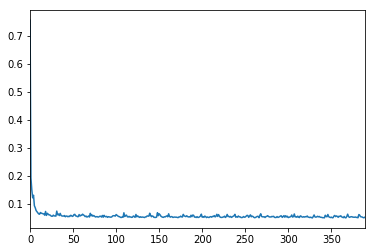

In [552]:
pd.Series(trainer.loss_results).plot()

In [553]:
pd.Series(trainer.loss_results).min(), trainer.loss_results[-1]

(0.04938359558582306, 0.05203275382518768)

In [554]:
# this is to change the behavior of batch normalization to evaluation mode
net.eval()

NeuralNet(
  (activation): LeakyReLU(negative_slope=0.01)
  (sigmoid): Sigmoid()
  (layers): ListModule(
    (0): Linear(in_features=2, out_features=400, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=400, out_features=400, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=400, out_features=400, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=400, out_features=400, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=400, out_features=3, bias=True)
  )
)

In [555]:
# generate some predictions and visually inspect to see how well the predictions match true values
# keep in mind the right most column is the CDF, the other two columns are Y
test_pred = net(test_x).cpu().detach().numpy()

In [556]:
test_y

tensor([[-0.5069, -0.4925,  0.0000],
        [ 1.0781, -0.4925,  1.0000],
        [ 0.5549, -0.4925,  0.0000],
        ...,
        [ 1.0414, -0.4925,  0.0000],
        [ 1.2338, -0.4925,  0.0000],
        [ 0.4188,  2.1885,  1.0000]], device='cuda:0')

In [557]:
test_pred

array([[-0.5087, -0.4745,  0.1294],
       [ 1.1023, -0.4852,  0.5964],
       [ 0.6048, -0.4746,  0.1946],
       ...,
       [ 1.0918, -0.4755,  0.3869],
       [ 1.2764, -0.4752,  0.4937],
       [ 0.4503,  2.2474,  0.4921]], dtype=float32)

In [558]:
test_pred[:, 0].mean(), y1.mean()

(-0.0013153845, 7.339906460401835e-17)

Text(0.5, 1.0, 'CDF correlation')

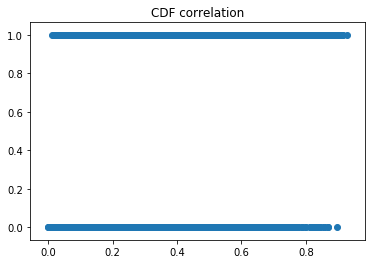

In [559]:
# this is more informative with the other CDF function - it typically shows a stright line
# here this means nothing
plt.scatter(test_pred[:10000, -1], test_y[:10000, -1].cpu().numpy())
plt.title('CDF correlation')

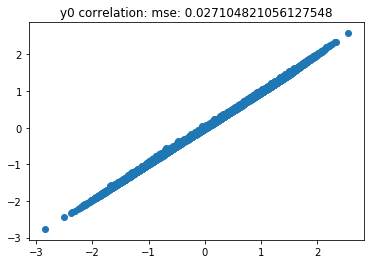

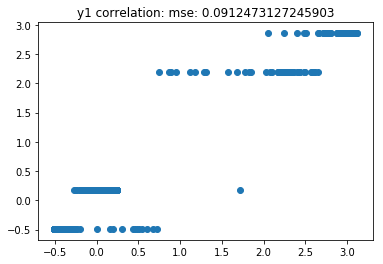

In [560]:
for i in [0, 1]:
    plt.scatter(test_pred[:10000, i], test_y[:10000, i].cpu().numpy())
    mse = np.sqrt(((test_pred[:10000, i] - test_y[:10000, i].cpu().numpy())**2).mean())
    plt.title(f'y{i} correlation: mse: {mse}')
    plt.show()

In [561]:
# now we can 'inspect the model'
# in this example we do a grid search over featurespace - generating Y, CDF values for each spot on the grid.

preidiction_shape = 50

f1_center = (np.max(f1) + np.min(f1)) / 2
f1_range = (np.max(f1) - np.min(f1)) / 2 * 1.02

f1_ticks = np.linspace(f1_center - f1_range, f1_center + f1_range, preidiction_shape)

f2_center = (np.max(f2) + np.min(f2)) / 2 
f2_range = (np.max(f2) - np.min(f2)) / 2 * 1.02

f2_ticks =  np.linspace(f2_center - f2_range, f2_center + f2_range, preidiction_shape)


grid = []
for i1 in f1_ticks:
    for i2 in f2_ticks:
        grid.append([i1, i2])
        

In [562]:
probe_x = torch.cuda.FloatTensor(grid)
p = net(probe_x).cpu().detach().numpy()

In [563]:
# calculate the 'true' CDF values given the grid
# this is useful in diagnosing issues with the predicted values
true_cdf = []


for i1, i2 in grid:
    sel = X[:,0] < i1
    sel &= X[:,1] < i2
    
    true_cdf.append(sel.mean())

true_cdf = np.array(true_cdf)

In [564]:
# given a CDF's grid representation - generate a plausable PDF (density)
def cdf_to_pdf(mat):
    mat = mat.copy() 
    xlen, ylen = mat.shape
    
    epsalon = 1/np.sum(mat.shape) * 1/1000

    
    for i in range(1, xlen):
        for j in range(1, ylen):
            mat[i,j] = np.max([
                mat[i,j], 
                mat[i-1,j], 
                mat[i,j-1], 
                mat[i-1,j-1]])
    
    mat[mat >= 1] = 1.0  
    
    mat_ret = mat.copy()
    
    ret = np.zeros(mat.shape)
    
    for j in range(0, xlen):
        for i in range(0, ylen):
            
            v = mat[i,j]
            if v > epsalon:

                mat[i:,j:] -= v

                ret[i,j] = v
              
    ret = ret / ret.sum()
    
    return ret, mat_ret



In [565]:
true_cdf = true_cdf.reshape(preidiction_shape,preidiction_shape)
true_pdf, _ = cdf_to_pdf(true_cdf)



cdf_prediction = p[:, -1].reshape(preidiction_shape, preidiction_shape)

pdf_prediction, cdf_mod = cdf_to_pdf(cdf_prediction)

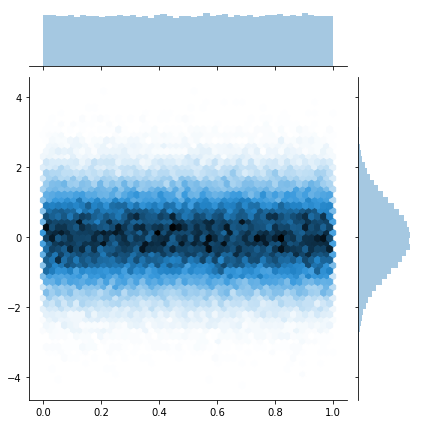

In [566]:
# inspect the actual distribution of f2 and f1
# this is equivalent to writing a query against the table
sns.jointplot(x=f2, y=f1, kind="hex")

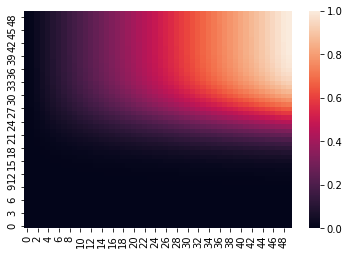

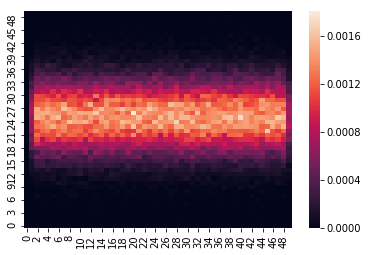

In [567]:
# inspect what the true CDF and density look like (hint, very similar to above)
ax = sns.heatmap(true_cdf)
ax.invert_yaxis()
plt.show()
ax = sns.heatmap(true_pdf)
ax.invert_yaxis()

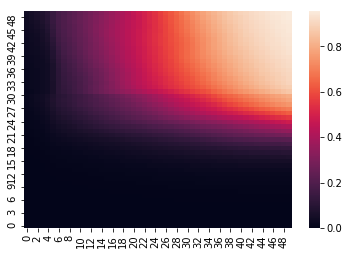

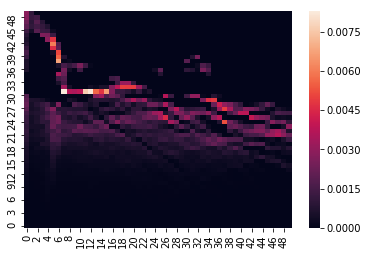

In [568]:
# inspect the predicted CDF and density
ax = sns.heatmap(cdf_prediction)
ax.invert_yaxis()
plt.show()
ax = sns.heatmap(pdf_prediction)
ax.invert_yaxis()

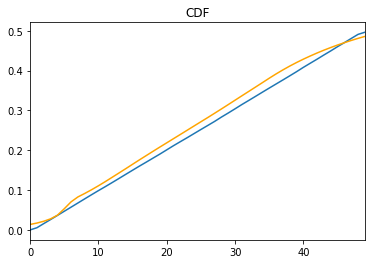

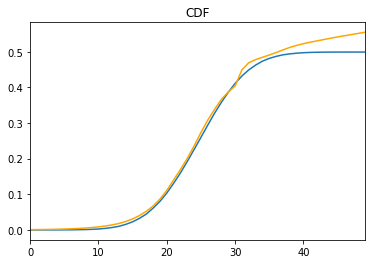

In [569]:
#inspect marginal CDF - we can see that the model has learned these two views somewhat 
for ax in [0,1]:
    pd.Series(true_cdf.mean(axis=ax)).plot() 
    pd.Series(cdf_mod.mean(axis=ax)).plot(color='orange', title='CDF') 
    plt.show()

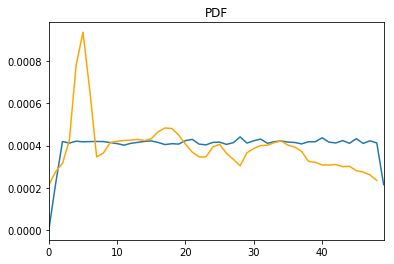

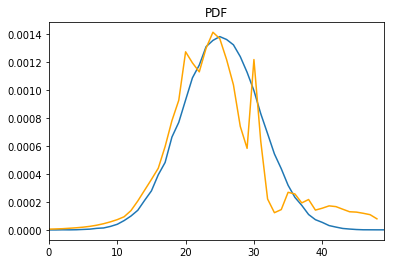

In [570]:
#inspect marginal PDF
for ax in [0,1]:
    pd.Series(true_pdf.mean(axis=ax)).plot() 
    pd.Series(pdf_prediction.mean(axis=ax)[1:]).plot(color='orange', title='PDF') 
    plt.show()

In [571]:
true_pdf.sum(), pdf_prediction[1:].sum()

(0.9999999999999999, 0.9989910611254658)

### Putting it all together
Now we calculate E[metric | data] * P(data) to get E[metric]

As you can see - it almost works!

In [572]:
de_norm(y1, y1_param).mean()

5.010736083713615

In [573]:
de_norm(y2, y2_param).mean()

8.67395

In [574]:
np.sum(de_norm(p[:,0], y1_param) * pdf_prediction.reshape(-1))

4.718857941546003

In [575]:
np.sum(de_norm(p[:,1], y2_param) * pdf_prediction.reshape(-1))

10.55730671649119